# Анализ тональности текста (Sentiment analysis)

Используемый датасет: Оценки критиков IMDB (https://www.kaggle.com/competitions/word2vec-nlp-tutorial/data)

In [ ]:
!pip install -r requirements.txt

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

import warnings


warnings.filterwarnings('ignore')
nltk.download('stopwords')

## Поверхностный анализ данных

In [3]:
train_data = pd.read_csv("./data/labeledTrainData.tsv", delimiter="\t")
test_data = pd.read_csv("./data/testData.tsv", delimiter="\t")

In [4]:
train_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
test_data.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


Датасет состоит из трех признаков:

* __id__ - id отзыва (категориальный признак)
* __review__ - текст отзыва (категориальный признак)
* __sentiment__ - целевоой признак - оценка (0 - негативная, 1 - положительная) (бинарный признак)

In [6]:
# id не несете никакой смысловой нагрузки, от него можно избавиться
train_data = train_data.drop(columns=["id"], axis=1)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  int64 
 1   review     25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


## Разведовательный анализ данных

Рассмотрим распределение образцов (записей в датасете) к значениям целевого признака (0 и 1)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

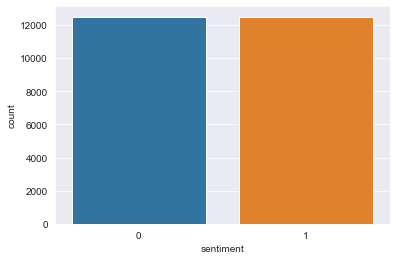

In [29]:
sns.countplot(train_data["sentiment"])

Визуализируем следующую информацию:

* распределение длины отзыва

* распределение количества слов в отзыве

<AxesSubplot:xlabel='word number', ylabel='Density'>

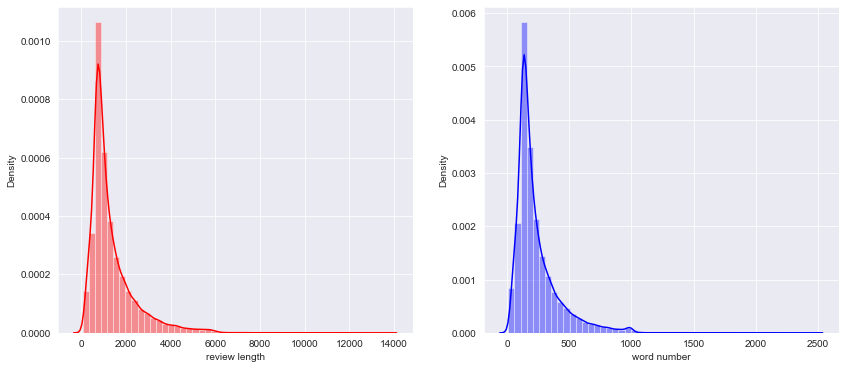

In [33]:
train_len = train_data["review"].apply(len).rename("review length")
train_count = train_data["review"].apply(lambda row: len(str(row).split(" "))).rename("word number")

fig=plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
sns.distplot(train_len,color='red')
fig.add_subplot(1,2,2)
sns.distplot(train_count,color='blue')

In [34]:
train_len.describe()

count    25000.000000
mean      1327.710560
std       1005.239246
min         52.000000
25%        703.000000
50%        981.000000
75%       1617.000000
max      13708.000000
Name: review length, dtype: float64

In [35]:
train_count.describe()

count    25000.000000
mean       233.786240
std        173.745845
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: word number, dtype: float64

Как можно видеть среди данных нет перевеса в пользу какого-то одного из значений (0 или 1). Следовательно обучающая выборка сбалансирована

Построим облако слов, которые часто встречаются в отзывах

In [9]:
from wordcloud import WordCloud, STOPWORDS

cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(" ".join(train_data["review"]))

(-0.5, 799.5, 599.5, -0.5)

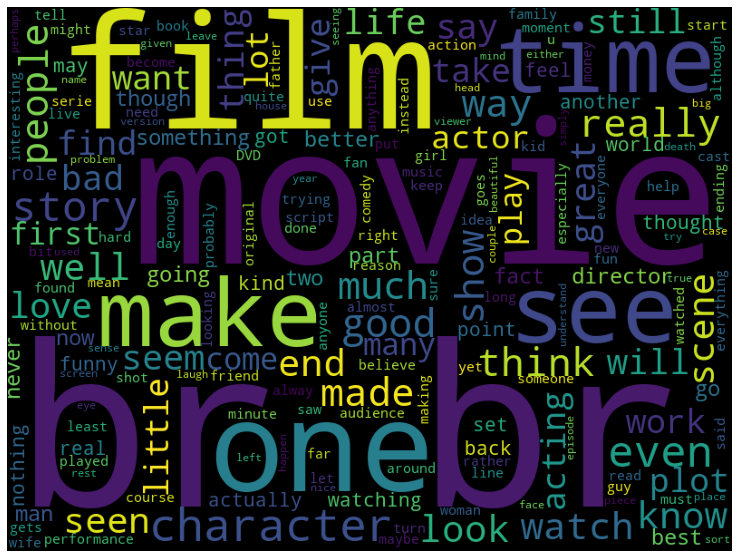

In [10]:
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

Как можно видеть среди слов есть различные HTML-теги

Избавимся от них, а также сделаем полезные для обучения преобразования текста

In [14]:
from bs4 import BeautifulSoup
import re


def preprocess_text(raw: str) -> str:
    """Функция предобработки текстовых данных."""

    # удаляем HTML-теги
    text = BeautifulSoup(raw, "lxml").get_text()

    # удаляем не-слова (цифры, пробелы и прочее), заменяя их на пробел
    letters_only = re.sub("[^a-zA-Z]", " ", text)

    # переводим в нижний регистр
    lowercase_text = letters_only.lower()

    # удаляем стоп-слова (союзы, предлоги и прочее)
    no_stop_words = [word for word in lowercase_text.split() if word not in set(stopwords.words("english"))]

    # объединяем получившееся в предложение
    return " ".join(no_stop_words)

In [31]:
clear_train = train_data.copy()
clear_train["review"] = clear_train["review"].apply(preprocess_text)

(-0.5, 799.5, 599.5, -0.5)

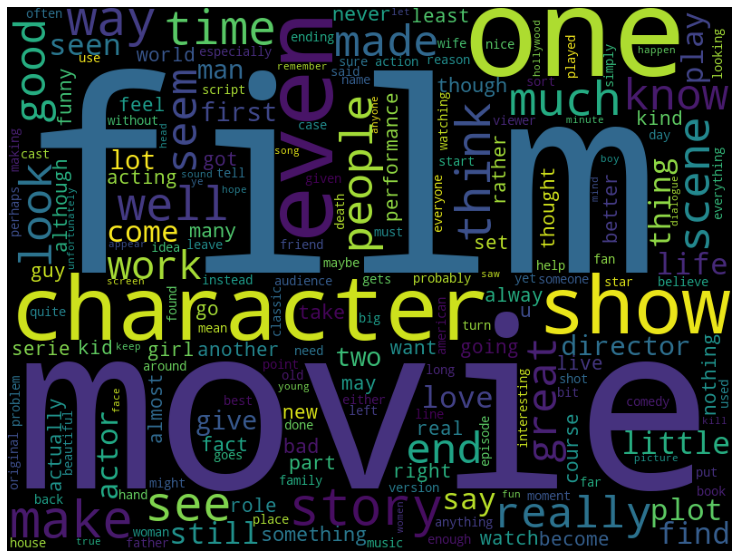

In [32]:
cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(" ".join(clear_train["review"]))
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

In [37]:
clear_train.to_csv("./data/clear_train_data.csv", index=False)